# Módulo Deep Learning y computer vision - practica final

Jose Del Hierro

1. Carga de datos
2. Preprocesado de los datos
3. Hito 1: Modelos 1D
4. Hito 2: Modelos 2D
5. Hito 3: Late-fusion
6. Hito 4: Early-fusion
7. Resultados
8. Discusión

In [ ]:
# permitimos el acceso a nuestra carpeta de GDrive para simplificar el proceso,
# si bien podríamos subir manualmente los datos a mano.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Carga de los datos

En primer lugar debemos cargar las librerías necesarias para interactuar con datos que tengamos en local, o en Google Drive.

In [ ]:
import pandas
from pathlib import Path

DATA_DIR = "/content/drive/MyDrive/deep_learning-main/practica"
METADATA = "HAM10000_metadata.csv"
IMAGES = "hnmist_28_28_RGB.csv"

def load_dataset(N: int = None):
    """ Load the dataset up to `N` samples. If `N` is None, load the entire dataset. """
    metadata = pandas.read_csv(Path(DATA_DIR) / METADATA)
    images = pandas.read_csv(Path(DATA_DIR) / IMAGES)
    if N is not None:
        metadata = metadata[:N]
        images = images[:N]
    return metadata, images

tab_data, im_data = load_dataset()

Visualizamos las primeras muestras:

In [ ]:
tab_data.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
im_data.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92
5,8,1,3,19,5,10,26,8,13,34,...,15,12,3,7,5,0,1,4,0,0
6,194,147,137,197,148,139,197,148,132,200,...,158,211,160,163,211,162,166,208,162,166
7,161,121,105,169,128,119,172,129,116,176,...,113,141,103,92,87,59,56,32,18,19
8,125,84,85,165,114,118,181,120,125,188,...,111,119,80,79,62,35,41,19,8,13
9,228,179,194,227,174,191,226,165,182,215,...,138,217,142,156,219,154,166,216,146,154


## 2. Preprocesado de los datos

En primer lugar, eliminamos aquellas columnas de metadatos que no aporten información útil a nuestro proceso de modelado. Igualmente, identificamos la columna `dx` como nuestra columna de etiquetas. Por comodidad en el futuro, la renombramos para que no haya lugar a confusiones más adelante.

In [ ]:
tab_data = tab_data.drop(columns=['lesion_id', 'image_id'])
# Se elimina lesion_id e image_id porque no nos sirven
tab_data.rename(columns={'dx': 'label'}, inplace=True)
tab_data.head(10)

,label,dx_type,age,sex,localization
0,bkl,histo,80.0,male,scalp
1,bkl,histo,80.0,male,scalp
2,bkl,histo,80.0,male,scalp
3,bkl,histo,80.0,male,scalp
4,bkl,histo,75.0,male,ear
5,bkl,histo,75.0,male,ear
6,bkl,histo,60.0,male,face
7,bkl,histo,60.0,male,face
8,bkl,histo,70.0,female,back
9,bkl,histo,70.0,female,back


In [ ]:
tab_data.columns

Index(['label', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [ ]:
for col in tab_data.columns:
    print(col, tab_data[col].unique())

label ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dx_type ['histo' 'consensus' 'confocal' 'follow_up']
age [80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30. nan  5. 25. 20. 10.
 15.]
sex ['male' 'female' 'unknown']
localization ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


Hay valores de "Unknown", vamos a ver cuantos son para determinar que hacer mejor

In [ ]:
def unknown_stats(col):
    total = len(tab_data)
    unknown_count = (tab_data[col] == "unknown").sum()
    percentage = unknown_count / total * 100
    print(f"{col.upper():<15}: {unknown_count} unknowns ({percentage:.2f}%)")

unknown_stats("sex")
unknown_stats("localization")


SEX            : 57 unknowns (0.57%)
LOCALIZATION   : 234 unknowns (2.34%)


Eliminamos los valores de "Unknown" porqe no representan ni el 5 % de los valores y al ser categóricos no se puede imputar directamente

In [ ]:
tab_data = tab_data[tab_data["sex"] != "unknown"]
tab_data = tab_data[tab_data["localization"] != "unknown"]

In [ ]:
for col in tab_data.columns:
    print(col, tab_data[col].unique())

label ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dx_type ['histo' 'consensus' 'confocal' 'follow_up']
age [80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30.  5. 25. 20. nan 10.
 15.]
sex ['male' 'female']
localization ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


 **Revisando valores nulos**

In [ ]:
(tab_data.isnull().mean() * 100).round(2)

,0
label,0.0
dx_type,0.0
age,0.1
sex,0.0
localization,0.0


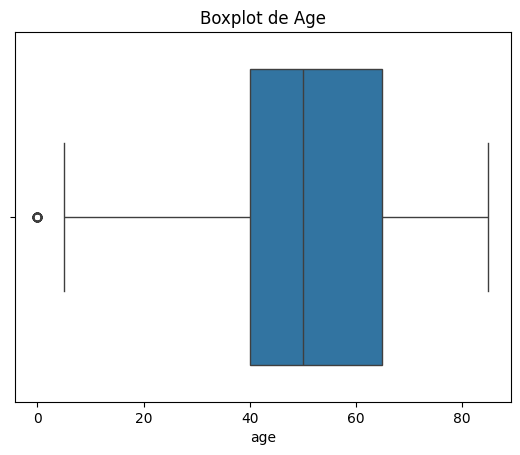

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=tab_data["age"])
plt.title("Boxplot de Age")
plt.show()

In [ ]:
tab_data["age"].min(), tab_data["age"].max()

(0.0, 85.0)

**Al ser una variable de edad es muy posible que este valor del outlier sea real (0)**

Llenamos los valores nulos con la mediana porque hay outliers

In [ ]:
median_age = tab_data["age"].median()

tab_data["age"] = tab_data["age"].fillna(median_age)

In [ ]:
(tab_data.isnull().mean() * 100).round(2)

,0
label,0.0
dx_type,0.0
age,0.0
sex,0.0
localization,0.0


**Volviendo las categóricas numéricas**

In [ ]:
tab_col_translation = {}
dx_type = tab_data['dx_type']
for col in ["label", "dx_type", "sex"]:
    factorized = pandas.factorize(tab_data[col])
    tab_data[col] = factorized[0]
    tab_col_translation[col] = factorized[1]
tab_data.head(10)

,label,dx_type,age,sex,localization
0,0,0,80.0,0,scalp
1,0,0,80.0,0,scalp
2,0,0,80.0,0,scalp
3,0,0,80.0,0,scalp
4,0,0,75.0,0,ear
5,0,0,75.0,0,ear
6,0,0,60.0,0,face
7,0,0,60.0,0,face
8,0,0,70.0,1,back
9,0,0,70.0,1,back


In [ ]:
tab_col_translation

{'label': Index(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype='object'),
 'dx_type': Index(['histo', 'consensus', 'confocal', 'follow_up'], dtype='object'),
 'sex': Index(['male', 'female'], dtype='object')}

One hot encoding a "localization"

In [ ]:
localizations = pandas.get_dummies(tab_data['localization']).astype(int)
tab_data = pandas.concat(
    [
        tab_data.drop(columns=['localization']),
        localizations
    ],
    axis=1
)
tab_data.head(10)

,label,dx_type,age,sex,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,upper extremity
0,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,80.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,75.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0,0,60.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,60.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,70.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,70.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


La columna `dx_type` no se vislumbra muy bien si nos pueda servir, por ello vamos a revisar la correlación que esta pueda tener con `label`

In [ ]:
tab_data[['label', 'dx_type']].corr()

,label,dx_type
label,1.000000,-0.332148
dx_type,-0.332148,1.000000


Separamos las `features` de manera explícita

In [ ]:
labels = tab_data['label']
tab_data = tab_data.drop(columns=['label', 'dx_type'])

Ahora, procedemos con la normalización de las imágenes.(2D)

In [ ]:
im_data = im_data / 255.0
im_data.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,0.752941,0.600000,0.756863,0.764706,0.607843,0.752941,0.772549,0.603922,0.725490,0.792157,...,0.525490,0.678431,0.486275,0.541176,0.717647,0.576471,0.650980,0.725490,0.603922,0.694118
1,0.098039,0.054902,0.117647,0.266667,0.188235,0.294118,0.482353,0.364706,0.494118,0.619608,...,0.321569,0.235294,0.152941,0.215686,0.098039,0.054902,0.109804,0.098039,0.054902,0.105882
2,0.752941,0.541176,0.600000,0.784314,0.568627,0.639216,0.788235,0.556863,0.627451,0.807843,...,0.584314,0.654902,0.505882,0.560784,0.623529,0.486275,0.556863,0.533333,0.407843,0.458824
3,0.149020,0.074510,0.117647,0.372549,0.231373,0.282353,0.560784,0.403922,0.466667,0.670588,...,0.286275,0.172549,0.101961,0.141176,0.098039,0.047059,0.066667,0.098039,0.047059,0.058824
4,0.619608,0.443137,0.545098,0.760784,0.564706,0.682353,0.843137,0.635294,0.749020,0.882353,...,0.788235,0.819608,0.650980,0.725490,0.674510,0.529412,0.584314,0.427451,0.305882,0.360784
5,0.031373,0.003922,0.011765,0.074510,0.019608,0.039216,0.101961,0.031373,0.050980,0.133333,...,0.058824,0.047059,0.011765,0.027451,0.019608,0.000000,0.003922,0.015686,0.000000,0.000000
6,0.760784,0.576471,0.537255,0.772549,0.580392,0.545098,0.772549,0.580392,0.517647,0.784314,...,0.619608,0.827451,0.627451,0.639216,0.827451,0.635294,0.650980,0.815686,0.635294,0.650980
7,0.631373,0.474510,0.411765,0.662745,0.501961,0.466667,0.674510,0.505882,0.454902,0.690196,...,0.443137,0.552941,0.403922,0.360784,0.341176,0.231373,0.219608,0.125490,0.070588,0.074510
8,0.490196,0.329412,0.333333,0.647059,0.447059,0.462745,0.709804,0.470588,0.490196,0.737255,...,0.435294,0.466667,0.313725,0.309804,0.243137,0.137255,0.160784,0.074510,0.031373,0.050980
9,0.894118,0.701961,0.760784,0.890196,0.682353,0.749020,0.886275,0.647059,0.713725,0.843137,...,0.541176,0.850980,0.556863,0.611765,0.858824,0.603922,0.650980,0.847059,0.572549,0.603922


Seguimos ya con los datos listos a la división de los mismos entre tran test y validation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tab_data, labels, test_size=0.3, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

Convertimos la edad en números acotados entre `[0, 1]`, imputando valores que están missing. Alternativamente, eliminamos esas muestras (en cuyo caso tendremos que eliminar también las imágenes asociadas del dataset):

<Axes: ylabel='age'>

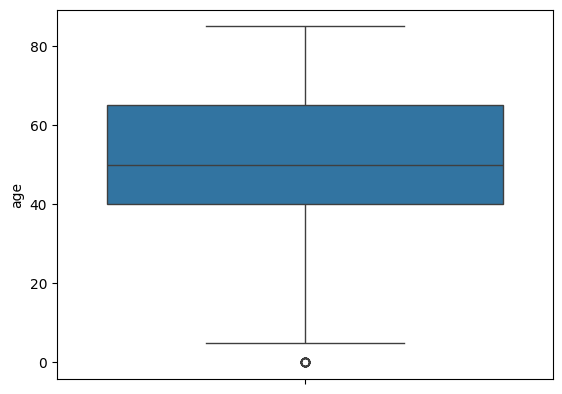

In [ ]:
import seaborn as sns
sns.boxplot(X_train['age'])


<Axes: >

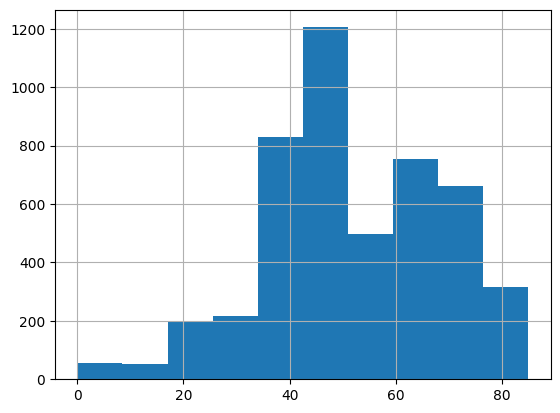

In [ ]:
X_train['age'].hist()

In [ ]:
from sklearn.preprocessing import StandardScaler

age_scaler = StandardScaler()
X_train['age'] = age_scaler.fit_transform(X_train[['age']])
X_val['age']   = age_scaler.transform(X_val[['age']])
X_test['age']  = age_scaler.transform(X_test[['age']])


En el análisis exploratorio Se descubrieron algunas columnas con datos o desconocidos o nulos. al ser estos menores al 5% de cada columna, opté por mejor eliminarlos y no ingresar datos artificiales al dataset.
Después de esto procedí a normalizar la variable age con StandardScaler para hacer el modelo más estable.

Separamos ahora las imágenes

In [ ]:
im_train = im_data.loc[X_train.index]
im_val = im_data.loc[X_val.index]
im_test = im_data.loc[X_test.index]

Como trabajamos sobre imágenes RGB, escalaremos cada canal por separado. Por comodidad, convertiremos las imágenes que estan actualmente aplanadas, a su representación 2D (28 x 28) para luego volver a aplanarlas y asi no se pierdan los colores.

In [ ]:
im_scaler = [StandardScaler() for _ in range(3)]
batched_imgs_train = im_train.values.reshape(-1, 28*28, 3)
batched_imgs_val = im_val.values.reshape(-1, 28*28, 3)
batched_imgs_test = im_test.values.reshape(-1, 28*28, 3)
for c, channel in enumerate(['R', 'G', 'B']):
    im_channel = batched_imgs_train[..., c]
    im_scaler[c].fit(im_channel)
    batched_imgs_train[..., c] = im_scaler[c].transform(im_channel)
    batched_imgs_val[..., c] = im_scaler[c].transform(batched_imgs_val[..., c])
    batched_imgs_test[..., c] = im_scaler[c].transform(batched_imgs_test[..., c])

print(f"Inmediatamente post-normalización: {batched_imgs_train.shape}")

im_train = batched_imgs_train.reshape(-1, 28 * 28 * 3)
im_val = batched_imgs_val.reshape(-1, 28 * 28 * 3)
im_test = batched_imgs_test.reshape(-1, 28 * 28 * 3)
print(f"Vuelta a versión aplanada: {im_train.shape}")


Inmediatamente post-normalización: (4787, 784, 3)
Vuelta a versión aplanada: (4787, 2352)


Finalmente, convertimos las etiquetas a su representación *one-hot*.

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

## 3. Hito 1: Modelos 1D

Importaciones previas

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


Definimos la función para entrenar nuestra red con los parámetros deseados

In [ ]:
def train_tab_model(activation_function, learning_rate, batch_size, num_epochs):

    # Entrada:
    input_tab = Input(shape=(X_train.shape[1],))

    x = Dense(100, activation=activation_function)(input_tab)
    x = Dense(64, activation=activation_function)(x)
    x = Dense(32, activation=activation_function)(x)
    # Salida
    output_tab = Dense(y_train_.shape[1], activation="softmax")(x)

    model = Model(inputs=input_tab, outputs=output_tab)

    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

    print("[INFO]: Entrenando red tabular...")
    # Entrenando la solución
    H = model.fit(X_train, y_train_,validation_data=(X_val, y_val_),epochs=num_epochs,batch_size=batch_size,verbose=1)

    # Evaluando el modelo de predicción con las imágenes de test
    print("[INFO]: Evaluando red tabular...")
    preds = model.predict(X_test, batch_size=batch_size)
    print(classification_report(y_test_.argmax(axis=1), preds.argmax(axis=1)))

    # Curvas de entrenamiento
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.title("Hito 1 - Modelo tabular")
    plt.show()

    return model, H


[INFO]: Entrenando red tabular...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5719 - loss: 1.7627 - val_accuracy: 0.6652 - val_loss: 1.4912
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6695 - loss: 1.4013 - val_accuracy: 0.6652 - val_loss: 1.2350
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6580 - loss: 1.2092 - val_accuracy: 0.6652 - val_loss: 1.1427
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6608 - loss: 1.1358 - val_accuracy: 0.6652 - val_loss: 1.1090
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6767 - loss: 1.0717 - val_accuracy: 0.6652 - val_loss: 1.0889
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6643 - loss: 1.0846 - val_accuracy: 0.6652 - val_loss: 1.0743
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6608 - loss: 1.0635 - val_accuracy: 0.6652 - val_loss: 1.0627
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6682 - loss: 1.045

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


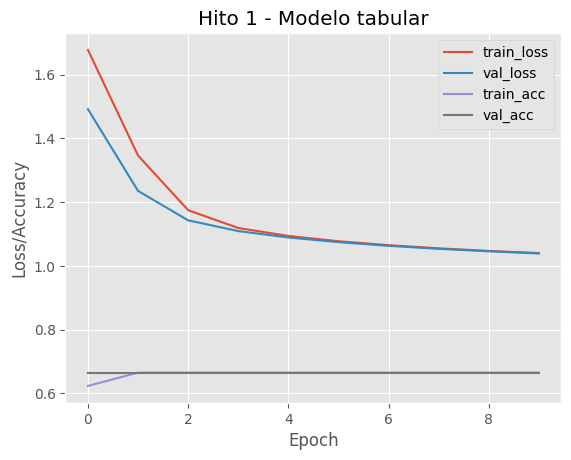

(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x7df6755fa030>)

In [ ]:
act = tf.nn.relu
learning_rate = 0.01
num_epochs = 10
batch_size = 128
train_tab_model(act, learning_rate, batch_size, num_epochs)

Empece con un Learning rate muy alto (0.1) para Adam, al utilizar (0.01) mejoró.
Se puede observar que la red está aprendiendo patrones y no hay un sobre ajuste (val_accuracy muy similar a accuracy).

Se puede explicar "algo" de la lesión con datos demográficos, sin embargo sin información visual no se puede confirmar de todo el tipo de lesión.


  Si bien ya sabemos que siempre hay margen de mejora, este parece sin duda un modelo bastante prometedor.

## 4. Hito 2: Modelos 2D

Aunque se puede diseñar una red neuronal desde cero, al tener un dataset de aproximadamente 10k imágenes, nos conviene usar un modelo preentrenado y realizar un fine tuning con algunas capas del backbone para adaptarlo bien a nuestro dataset. Enn este caso se usará EfficientNetBO y se descongelarán las últimas 10 capas por la cantidad de imágenes en HAM10000. Al tocar las capas profundas, corremos menos riesgo de que el modelo aprenda demasiado de nuestro dataset pero se liberan las capas finales, en las cuales estan los detalles más finos y los que en realidad necesita aprender nuestro modelo.

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

input_shape = (224, 224, 3)

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

# resize train set
X_train_resized = []
for img in X_train:
  X_train_resized.append(np.resize(img, input_shape) / 255)

X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)

# resize test set
X_test_resized = []
for img in X_test:
  X_test_resized.append(np.resize(img, input_shape) / 255)

X_test_resized = np.array(X_test_resized)
print(X_test_resized.shape)

Vamos a utilizar EfficientNetB0 debido a su pequeño tamaño, y por tanto su velocidad. Se debe redimensionar las imagenes ya que este modelo tiene un input de otro tamaño

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Resizing, GlobalAveragePooling2D

input_tensor = Input(shape=(28, 28, 3))
x = Resizing(224, 224)(input_tensor)
# Quitamos la "cabeza" del modelo para poder entrenar el nuestro con pocas imagenes
x = EfficientNetB0(weights='imagenet', include_top=False)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
output_tensor = Dense(y_train_.shape[1], activation='softmax', name='cls_head')(x)
vision = Model(inputs=input_tensor, outputs=output_tensor)

vision.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_head (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,772,010 (18.20 MB)

 Trainable params: 4,729,987 (18.04 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
im_train = im_train.reshape(-1, 28, 28, 3)
im_val = im_val.reshape(-1, 28, 28, 3)
im_test = im_test.reshape(-1, 28, 28, 3)

Congelamos el modelo principal a excepción de las últimas capas para hacer fine tuning con nuestras imágenes del dataset.

In [ ]:
for layer in vision.layers:
  if layer.name not in ['fc1', 'fc2', 'cls_head']:
    layer.trainable = False

N = 10
for layer in vision.layers[-N:]:
    layer.trainable = True
vision.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cls_head (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,216,890 (23.72 MB)

 Trainable params: 4,729,987 (18.04 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 1,444,880 (5.51 MB)

In [ ]:
  # compilamos
  vision.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # definimos el early-stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.005)

  # entrenamos
  im_train.shape
  H = vision.fit(im_train, y_train_, validation_data=(im_val, y_val_), epochs=200, callbacks=[early_stopping])

Epoch 1/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 293ms/step - accuracy: 0.6430 - loss: 1.2197 - val_accuracy: 0.6652 - val_loss: 1.1423
Epoch 2/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6707 - loss: 1.1331 - val_accuracy: 0.6652 - val_loss: 1.1454
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6654 - loss: 1.1506 - val_accuracy: 0.6652 - val_loss: 1.1398
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6724 - loss: 1.1379 - val_accuracy: 0.6652 - val_loss: 1.1346
Epoch 5/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6817 - loss: 1.1045 - val_accuracy: 0.6652 - val_loss: 1.1472
Epoch 6/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6659 - loss: 1.1398 - val_accuracy: 0.6652 - val_loss: 1.1491
Epoch 7/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6671 - loss: 1.1385 - val_accuracy: 0.6652 - val_loss: 1.1363
Epoch 8/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6696 - loss: 1.1269

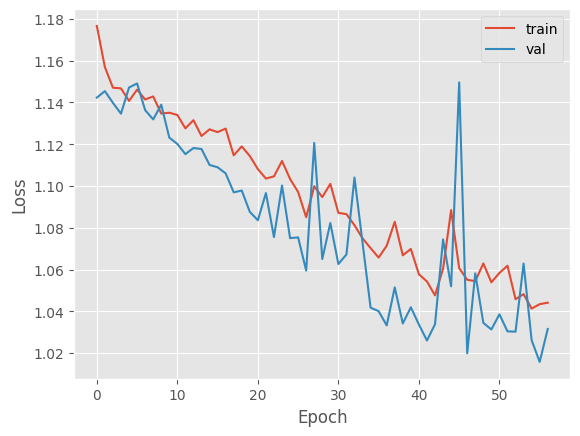

In [ ]:
fig, ax = plt.subplots()
ax.plot(H.history['loss'], label='train')
ax.plot(H.history['val_loss'], label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

## 5. Hito 3: late-fusion

## 6. Hito 4: Early-fusion


## 7. Resultados



## 8. Discusión
